In [1]:
%%html
<style>
table,td,tr,th {border:none !important; }
</style>

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Clustering and K-Means

_Authors: Dave Yerrington (SF), Joseph Nelson (DC)_

---

![](https://snag.gy/kYWumd.jpg)

### Learning Objectives
*After this lesson, you will be able to:*
- Understand basic unsupervised clustering problems
- Perform a K-Means Clustering Analysis
- Evaluate clusters for fit 

## 

### Lesson Guide
- [Unsupervised learning](#unsupervised)
- [Introduction to clustering](#intro)
- [What is clustering?](#what)
- [KNN review](#knn)
- [Clustering algorithms](#algos)
- [K-means clustering](#k-means)
- [Refresher: Euclidean distance](#euclidean)
- [K-Means step-by-step](#km-steps)
- [K-Means: a visual example](#vis)
- [K-Means caveats and pitfalls](#caveats)
    - [Sensitive to outliers](#sensitive)
    - [Sensitive to centroid initialization](#centroid-init)
    - [How many K?](#how-choose-k)
- [Choosing K](#choose-k)
- [A note on K-Means convergence](#converge)
- [K-Means in sklearn](#sklearn)
    - [Visually verifying cluster labels](#verify)
- [Metrics: inertia and the silhouette coefficient](#sil)
- [Practice: use K-Means on the "Isotopic Composition Plutonium Batches" data](#pluto)
    - [How does scaling affect fit?](#scaling)
- [Conclusion: K-Means tradeoffs](#conclusion)
- [Additional resources](#resources)

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

![](images/overview.png)

### We are going to explore unsupervised learning

<a id='unsupervised'></a>

## Unsupervised learning 

---

> **Supervised --> Classification** - create a model to predict which group a point belongs to: <br>
In this case we have clear labels and a metric of success (a correct/incorrect prediction)

> **Unsupervised --> Clustering** - find groups that exist in the data already: <br>
No labels and no clear metric of success.





| Pros  | Cons |
|---|---|
| No labels | Difficult to evaluate correctness without subject matter expertise |
| Few or no assumptions about data | Scaling / normalization often required |
| Useful for subset / segmentation discovery | Can be difficult to visualize |
| Great for broad insights | Not clear whether it's correctly labeled |
| Many models avalable | No obvious choice in many cases |
| Black magic | Considered "unconventional" and unreliable |

<a id='what'></a>
## What is Clustering? 

---

<img src="https://snag.gy/BdfATE.jpg" style="width: 500px">



Clustering is one of the most ubiquitous and widespread processes for assigning discrete structure to data. In clustering, we group observations in a dataset together such that the members of a group are more similar to each other than they are to members of other groups. There are a wide variety of methods and criteria to perform this task.

**Properties of clustering procedures:**
- No "true" target / response to compare
- We apply structure to data quantitatively based on specific criteria
- Predictions of label are based on the structure of the data

For example: your employer gives you a dataset of voter preferences from a local poll. They want you to figure out just exactly how these voters are grouping based on their preferences. The answer: clustering!

In [13]:
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
df = pd.DataFrame({'users': ['user ' + str(i) for i in range(1,11)],
             'show_1': [random.choice([1,0]) for i in range(1,11)],
             'show_2': [random.choice([1,0]) for i in range(1,11)]})
df

,users,show_1,show_2
0,user 1,1,1
1,user 2,1,0
2,user 3,1,1
3,user 4,0,1
4,user 5,1,0
5,user 6,0,1
6,user 7,0,0
7,user 8,0,1
8,user 9,0,0
9,user 10,1,1


### Examples

<a name="intro"></a>
## Introduction to clustering

---

### Helpful uses for clustering: 
   - Find items with similar behavior (users, products, voters, etc)
   - Market segmentation
   - Understand complex systems
   - Discover meaningful categories for your data
   - Reduce the number of classes by grouping (e.g. bourbons, scotches -> whiskeys)
   - Reduce the dimensions of your problem
   - Pre-processing! Create labels for supervised learning

### What are some examples that you can think of?

#### Coding Example


- We have a set of Tweets and we want to see what topics are in those tweets
- There is no set categories before hand and have not read the tweets

In [454]:
tweets_data = []
tweets_file = open('data/nytimeshealth.txt', "r")

for i in tweets_file:
    tweets_data.append(i.split('|')[2].split('http:')[0].replace('RT', '').strip())
    
health = pd.DataFrame({'tweets':tweets_data})

In [456]:
health.head()

,tweets
0,Risks in Using Social Media to Spot Signs of M...
1,@paula_span: The most effective nationwide dia...
2,The New Old Age Blog: Diabetes Prevention That...
3,Well: Comfort Casseroles for Winter Dinners
4,High-Level Knowledge Before Veterans Affairs S...


In [457]:
health.tweets[0]

'Risks in Using Social Media to Spot Signs of Mental Distress'

In [134]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer, ENGLISH_STOP_WORDS
from textblob import TextBlob, Word

tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union(['amp', 'does']),  max_features=50)
X = tfidf.fit_transform(health.tweets)

In [441]:
from skimage.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=1).fit(X)

df = pd.DataFrame(X.todense(), columns=tfidf.get_feature_names())
df['clusters'] = kmeans.labels_


In [442]:
df.clusters.value_counts()

1    4586
0     649
3     561
2     449
Name: clusters, dtype: int64

In [443]:
df[df.clusters == 0].drop(['clusters'], axis = 1).mean().sort_values(ascending = False).iloc[0:6]

ebola       0.740401
patient     0.062187
says        0.054914
hospital    0.042808
new         0.038468
health      0.031651
dtype: float64

In [444]:
df[df.clusters == 1].drop(['clusters'], axis = 1).mean().sort_values(ascending = False).iloc[0:6]

cancer      0.041808
cslnyt      0.027148
study       0.022771
briefing    0.022216
ask         0.022014
risk        0.021804
dtype: float64

In [445]:
df[df.clusters == 2].drop(['clusters'], axis = 1).mean().sort_values(ascending = False).iloc[0:6]

new           0.588034
old           0.270411
age           0.265792
blog          0.252288
paula_span    0.017733
care          0.017064
dtype: float64

In [446]:
df[df.clusters == 3].drop(['clusters'], axis = 1).mean().sort_values(ascending = False).iloc[0:6]

health     0.655400
care       0.153499
recipes    0.129458
global     0.106302
law        0.080137
new        0.070666
dtype: float64

# B. Two Models to Do Clustering

- K-Means
- Heirarchical Clustering

<a name="algos"></a>
## Clustering algorithms 

![](images/clustering_overview.png)

---

The are many different algorithms that can perform clustering given a dataset:

- **K-Means** (mean centroids)
- **Hierarchical** (nested clusters by merging or splitting successively)
- **DBSCAN** (density based)
- **Affinity Propagation** (graph based approach to let points 'vote' on their preferred 'exemplar')
- **Mean Shift** (can find number of clusters)
- **Spectral Clustering**
- **Agglomerative Clustering** (suite of algorithms all based on applying the same criteria/characteristics of one cluster to others)



Today we're going to look only at one of the algorithms: **k-means.**

## i. K-Means clustering

Uses assumptions from KNN:

- Distances 
- Each Features is a dimension


But instead of voting it calculates points that are closer together.

In [23]:
import seaborn as sns

In [48]:
iris = sns.load_dataset('iris')

to_plot = iris[['sepal_length', 'sepal_width']]
iris['species_num'] = iris.species.map({'setosa':0, 'versicolor':1, 'virginica':2})


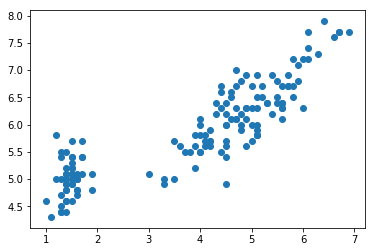

In [57]:
plt.scatter(x = iris.petal_length, y = iris.sepal_length)

### Group This Data Into 2 Groups

- How did you decide on the groups?
- How might you make this into a model

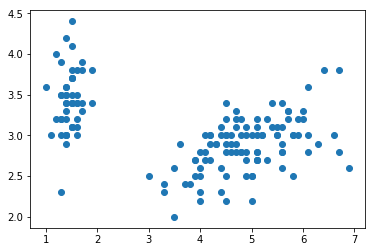

In [62]:
plt.scatter(x = iris.petal_length, y = iris.sepal_width)

### Group This Data Into 3 Groups

- How did you decide on the groups?


#### K-Means is the most popular clustering algorithm

K-means is one of the easier methods to understand and other clustering techniques use some of the same assumptions that K-Means relies on.

- **K** is the number of clusters.
- **Means** refers to the mean points of the K clusters.

The number of clusters $k$ is chosen in advance. The goal is to partition the data into set such that the total sum of squared distances from each point to the mean point of the cluster is minimized.

The algorithm takes your entire dataset and iterates over its features and observations to determine clusters based around center points. These center points are known as **centroids**. 

**K-means iterative fitting:**
1. Pick a value for k (the number of clusters to create)
2. Initialize k 'centroids' (starting points) in your data
3. Create your clusters. Assign each point to the nearest centroid. 
4. Make your clusters better. Move each centroid to the center of its cluster. 
5. Repeat steps 3-4 until your centroids converge (their classes no longer change). 

> **Note:** Unfortunately there is no formula to determine the absolute best number of $k$ clusters. Unsupervised learning is inherently subjective! We can, however, choose the "best" $k$ based on predetermined criteria. 

### Visualization:
http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html

<a id='km-steps'></a>
## K-Means step-by-step

---


<table width="500" cellpadding="50"> 
<tr>
   <td width="450">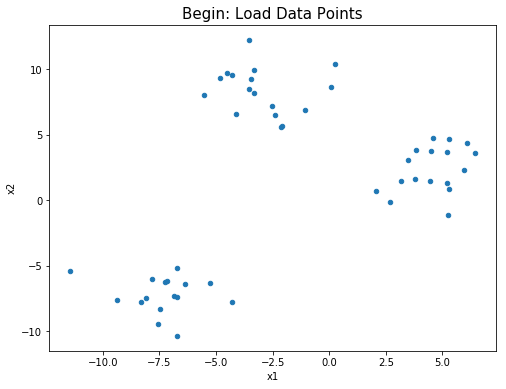</td>
   <td style="vertical-align: top; width: 400px;"><br><br>We begin by loading data in a N-Dimensional feature space <br>(2D for example).</td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td width="450">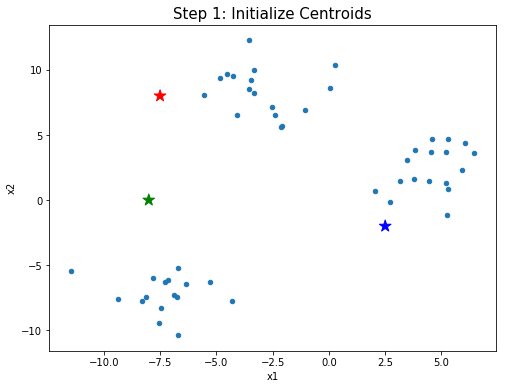</td>
   <td style="align: top; width: 400px; vertical-align: top;"><br><b>Step 1.</b><br>Intialize K centroid (3 here).</td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td width="450">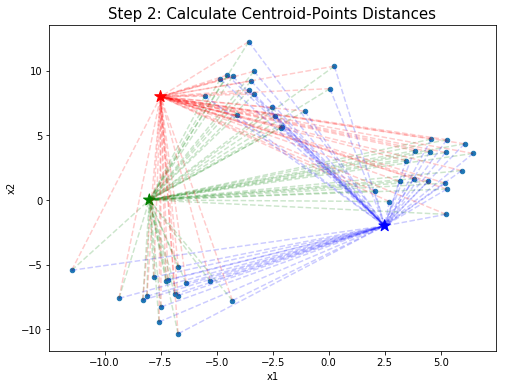</td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 2.</b><br>Assign points to *closest* cluster based on _euclidean distance_.<br><br>$\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}$

   </td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td width="450">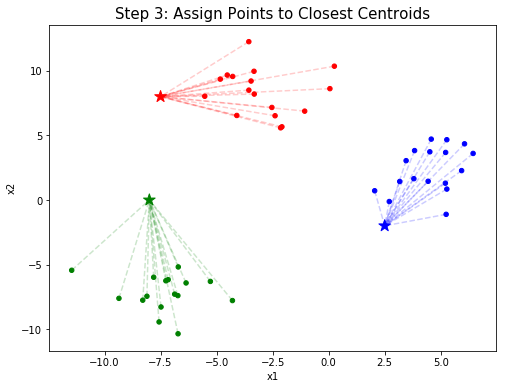</td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 3.</b><br>Calculate mean of points assigned to centroid (2 here).  Update new centroid positions to mean (ie: geometric center).<br><br>$new\ centroid\ position= \bar{x}, \bar{y}$
   </td>
</tr>
<tr>
</table>


<table width=500 cellpadding="50"> 
<tr>
   <td width="450">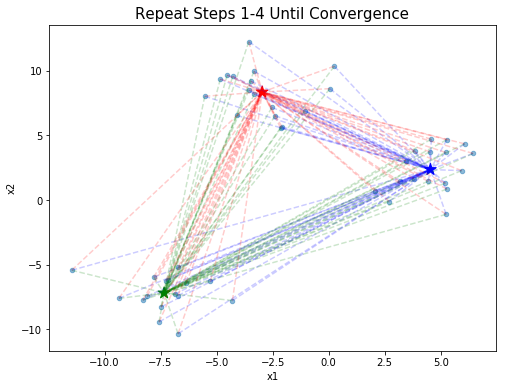</td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Step 4.</b><br>Repeat step 1-4, updating class membership based on centroid distance.
   </td>
</tr>
<tr>
</table>

<table width=500 cellpadding="50"> 
<tr>
   <td width="450">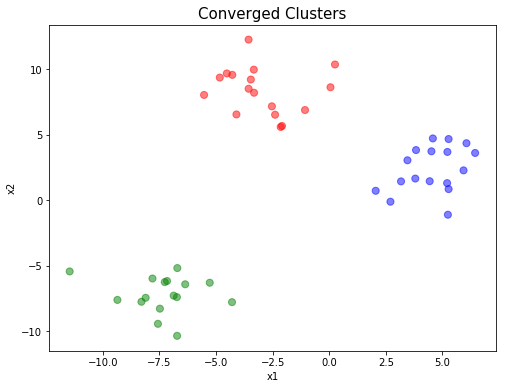</td>
   <td style="align: top; width: 400px; vertical-align: top;"><b>Fin.</b><br>Convergence is met once all points no longer change to a new class (defined by closest centroid distance).
   </td>
</tr>
<tr>
</table>

<a id='vis'></a>
## K-Means: Recap

---

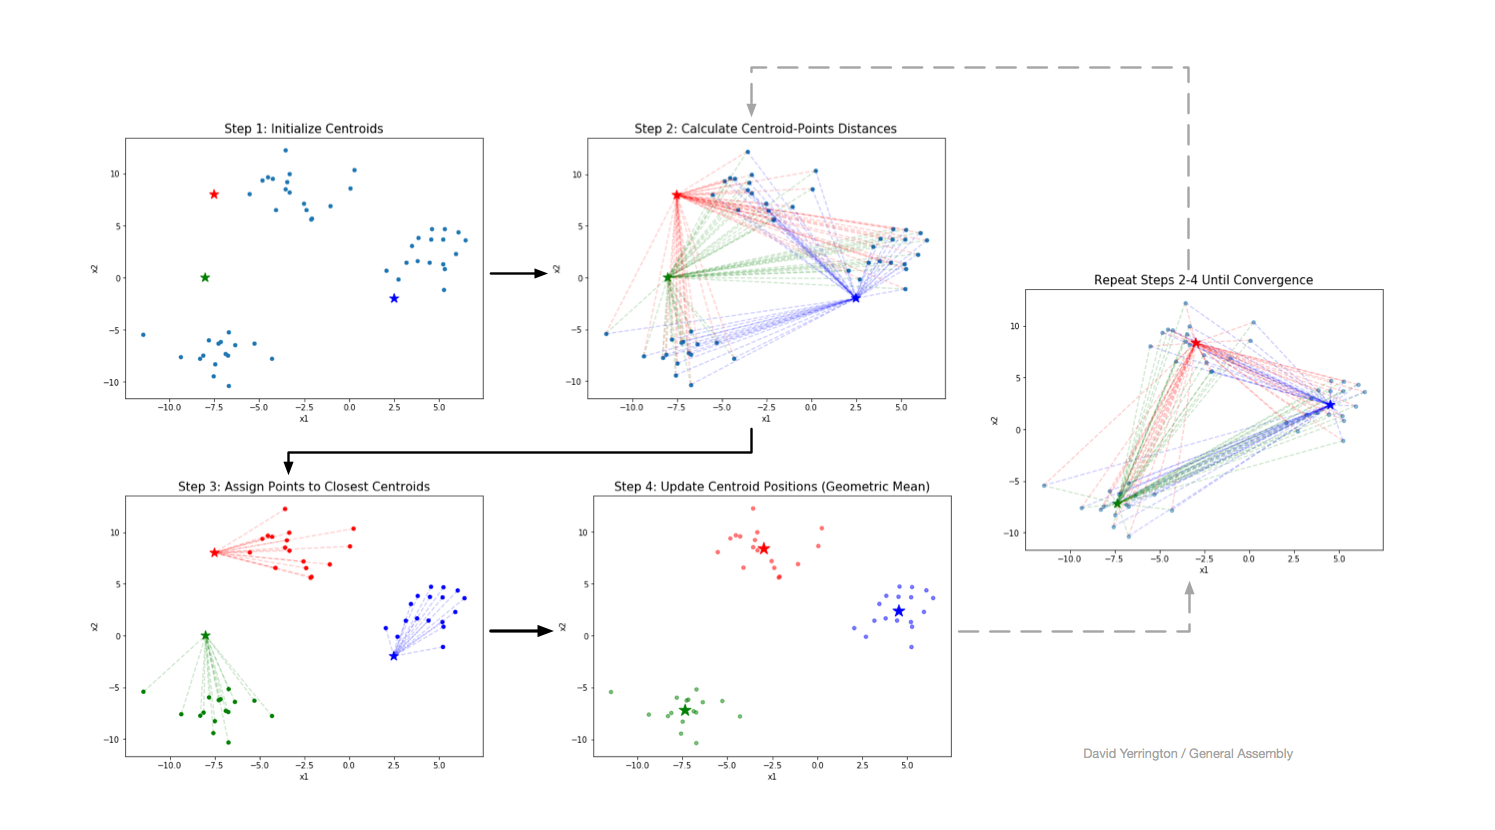

<a id='caveats'></a>
## A few K-Means caveats...

---

Now that we've learned the basic process for K-Means clustering, we should explore the idea that nothing's perfect!  Let's play a game called **"How will it converge!?"**.

### Scenario 1: Wispy Flat Blobs

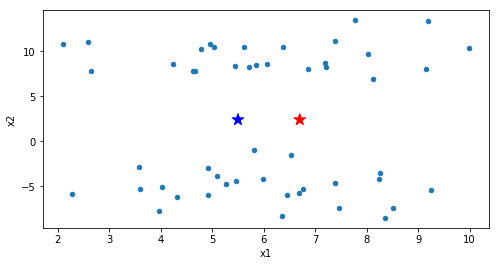

In [65]:
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt


X, color = make_blobs(n_samples=50, random_state=13, centers=2, cluster_std=2, )
X = map(lambda x: (x[0][0], x[0][1], color[x[1]]), zip(X, color))

points = pd.DataFrame(list(X), columns=["x1", "x2", "color"])
ax = points.plot(kind="scatter", x="x1", y="x2", figsize=(8, 4))

initial_centroids = pd.DataFrame([[5.5, 2.4, "b"], [6.7, 2.4, "r"]], columns=["x1", "x2", "color"])
initial_centroids.plot(kind="scatter", x="x1", y="x2", c=initial_centroids['color'], ax=ax, marker="*", s=150);

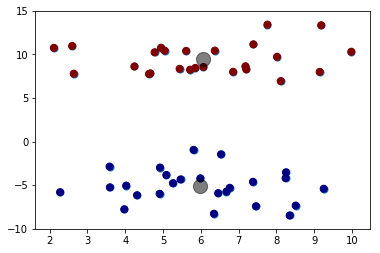

In [66]:
Z = np.array(points[['x1', 'x2']])
plt.scatter(Z[:, 0], Z[:, 1], s=50);

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)
plt.scatter(Z[:, 0], Z[:, 1], c=y_kmeans, s=50, cmap='jet')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Scenario 2:  The Lone Wolf Point

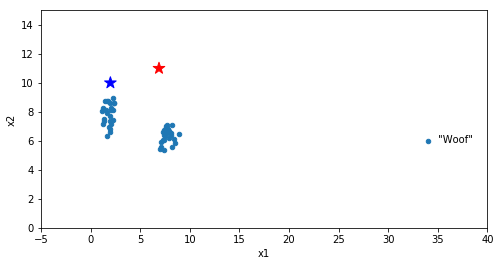

In [67]:
X, color = make_blobs(n_samples=50, random_state=20, centers=2, cluster_std=.5, )
X = list(map(lambda x: (x[0][0], x[0][1], color[x[1]]), zip(X, color)))

X.append([34, 6, 0])

points = pd.DataFrame(list(X), columns=["x1", "x2", "color"])
ax = points.plot(kind="scatter", x="x1", y="x2", figsize=(8, 4))
plt.text(35, 5.9, '"Woof"')
ax.set_ylim(top=15, bottom=0)
ax.set_xlim(left=-5, right=40)

initial_centroids = pd.DataFrame([[2, 10, "b"], [6.9, 11, "r"]], columns=["x1", "x2", "color"])
initial_centroids.plot(kind="scatter", x="x1", y="x2", c=initial_centroids['color'], ax=ax, marker="*", s=150);

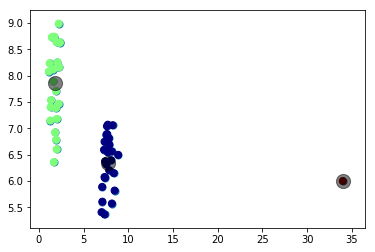

In [68]:
Z = np.array(points[['x1', 'x2']])
plt.scatter(Z[:, 0], Z[:, 1], s=50);

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)
plt.scatter(Z[:, 0], Z[:, 1], c=y_kmeans, s=50, cmap='jet')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

<a id='converge'></a>
## A note on K-Means convergence

---

In general, k-means will converge to a solution and return a partition of k clusters, even if no natural clusters exist in the data.  It's entirely possible – in fact, *common* – that the clusters do not mean anything at all. 

**Knowing your domain and dataset is essential. Evaluating the clusters visually is a must (if possible).**

> _"Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='kmeans++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization, as shown in the reference."_ [sklearn Clustering Guide](http://scikit-learn.org/stable/modules/clustering.html#k-means)

![](http://www.datamilk.com/kmeans_animation.gif)




<a id='choose-k'></a>
#### Initializing Centroids

---

There are different methods of initializing centroids. For instance:

- Randomly
- Special KMeans++ method in Sklearn (_This initializes the centroids to be generally distant from each other_): <br>

This is mitigated by Kmeans++:

- Choose one center uniformly at random from among the data points.
- For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
- Choose one new data point at random as a new center, using a weighted probability distribution where a point x is - chosen with probability proportional to D(x)2.
- Repeat Steps 2 and 3 until k centers have been chosen.
- Now that the initial centers have been chosen, proceed using standard k-means clustering.



In [458]:
from sklearn.cluster import KMeans

km = KMeans()

In [460]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<a id='how-many-k'></a>
### How many K?

Sometimes it's obvious, sometimes it's not!  What do you think?

- /poll "How many K:  Figure 1" "1" "2" "3" "4"
- /poll "How many K:  Figure 2" "1" "2" "3" "4"
- /poll "How many K:  Figure 3" "1" "2" "3" "4"

<table>
    <tr>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/4rU39.png"><br>1</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="http://i.stack.imgur.com/gq28F.png"><br>2</td>
        <td valign="bottom" style="vertical-align: bottom; text-align: center;"><img src="https://snag.gy/cWPgno.jpg"><br>3</td>
    </tr>
</table>

## K-Means in sklearn

---

Below we will using sklearn to apply K-Means.

In [510]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# Let's load some data to test K-Means on
df = pd.read_csv("./data/claim-income.csv", header=None)
col_names = ["claim-amount","income","coverage"]
df.columns = col_names
df.head()

,claim-amount,income,coverage
0,10.3900,31,118
1,20.8020,36,245
2,42.3240,30,953
3,9.5540,30,122
4,119.9331,52,285


All 3 variables in this dataset are in thousands of dollars, so the units are comparable for them. If some of your variables are on different scales (for example, height in feet and annual income in dollars), you need to make sure that unit scales are comparable by **standardizing** variables. Standardizing variables means rescaling them to have a mean of zero and a standard deviation of one.    

K-means looks for clusters in every direction, so we will almost always benefit from standardizing variables. If you don't, clusters will tend to be separated along variables with higher variance.

In [511]:
df.describe()

,claim-amount,income,coverage
count,50.000000,50.000000,50.000000
mean,57.314815,78.980000,281.980000
std,96.135976,75.594107,280.159975
min,2.668000,12.000000,60.000000
25%,9.401750,30.250000,107.250000
50%,21.690000,49.000000,168.500000
75%,52.634750,101.750000,294.750000
max,422.649000,328.000000,1085.000000


Variance of features is quite different. This would result observations being a lot closer (or similar) on one variable, but not on the other. A preprocessing step called Feature scaling is used to standardize observations.

In [512]:
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(StandardScaler().fit_transform(df[col_names]))
df.columns = col_names
df.describe()

/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,claim-amount,income,coverage
count,5.000000e+01,5.000000e+01,5.000000e+01
mean,1.443290e-17,-7.549517e-17,-6.883383e-17
std,1.010153e+00,1.010153e+00,1.010153e+00
min,-5.742036e-01,-8.950435e-01,-8.003772e-01
25%,-5.034484e-01,-6.511716e-01,-6.300113e-01
50%,-3.743291e-01,-4.006182e-01,-4.091666e-01
75%,-4.917597e-02,3.042720e-01,4.604386e-02
max,3.838763e+00,3.327616e+00,2.895391e+00


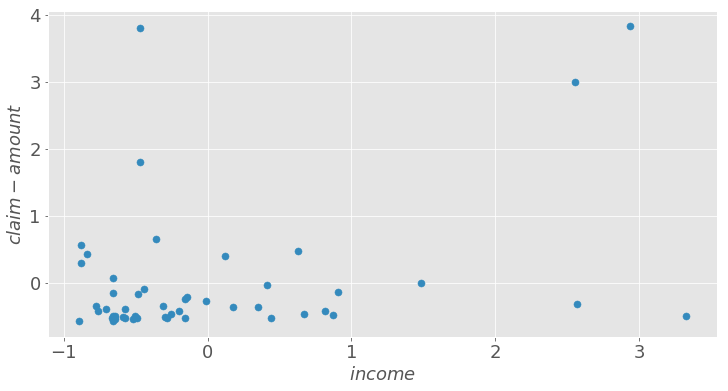

In [513]:
# Plot the scatter
ax = df.plot(kind="scatter", x="income", y="claim-amount", figsize=(12,6), s=50)
plt.xlabel("$income$", fontsize=18)
plt.ylabel("$claim-amount$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

In [514]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=1)
model = kmeans.fit(df)

After we fit our data, we can get our predicted labels from `model.labels_` and the center points`model.cluster_centers_`.

In [467]:
# Check out model params
model.cluster_centers_

array([[-0.24793989, -0.32979508, -0.3905075 ],
       [-0.10484926,  1.16665297,  1.74622606],
       [ 3.55051348,  1.67507752,  1.13223918]])

In [468]:
# attach predicted cluster to original points
df['predicted'] = model.labels_
df.head(10)

,claim-amount,income,coverage,predicted
0,-0.493064,-0.641149,-0.591251,0
1,-0.383660,-0.574335,-0.133336,0
2,-0.157517,-0.654512,2.419448,1
3,-0.501849,-0.654512,-0.576828,0
4,0.657964,-0.360530,0.010889,0
5,0.438009,-0.841592,-0.659758,0
6,-0.524545,-0.160087,-0.493899,0
7,-0.523872,-0.667875,-0.677786,0
8,0.564099,-0.881681,-0.616490,0
9,-0.475643,0.868852,-0.201843,0


### Visually verifying cluster labels

In [469]:
# Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(model.cluster_centers_, 
                         columns=['x1','x2','x3'])
centroids

,x1,x2,x3
0,-0.247940,-0.329795,-0.390507
1,-0.104849,1.166653,1.746226
2,3.550513,1.675078,1.132239


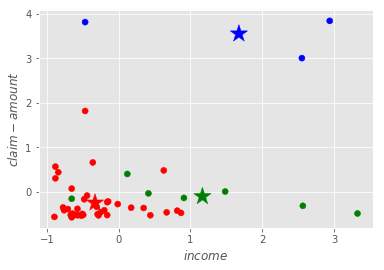

In [470]:
# Unique category labels that we set before
color_labels = df['predicted'].unique()

# List of RGB triplets
rgb_values = ['red','green','blue']

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))
color_map

# Finally use the mapped values
plt.scatter(df['income'], df['claim-amount'],
            c=df['predicted'].apply(lambda x: color_map[x]))
plt.xlabel("$income$", fontsize=12)
plt.ylabel("$claim-amount$", fontsize=12)
plt.scatter(centroids['x2'], centroids['x1'], marker='*', 
            color=rgb_values, s=330)
plt.show()

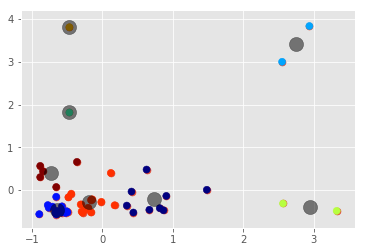

In [471]:
Z = np.array(df[['income', 'claim-amount']])
plt.scatter(Z[:, 0], Z[:, 1], s=50);

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8)
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)
plt.scatter(Z[:, 0], Z[:, 1], c=y_kmeans, s=50, cmap='jet')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Overview:

- Clustering is a form of unsupervised learning where data has no labels
- K-means is a clustering algorithm
- It groups data points by iteratively moving k centroids to the closest points
- The K number of clusters must be chosen
- They are effected by outliers
- Number of dimensions matter


### ii. Heirarchical Clustering

<a name="what-is"></a>
## What is hierarchical clustering?

---

Hierarchical clustering, like k-means clustering, is another common form of clustering analysis. With this type of clustering we seek to do exactly what the name suggests: 

- Build hierarchies of clusters.
- Connect the clusters in the hierarchy with links.

Once the links are determined, we can display them in what is called a **dendrogram** - a graph that displays all of these links in their hierarchical structure.

<img src="images/dendrogram-ex.png" alt="dendrogram" width="400"/>

To find clusters in a dendrogram, we can "cut" the graph to find the clusters - we'll go over this later in the lesson. 


There are 2 types Agglomorate and Divisive

We will cover agglomorate and show how divise is related

Agglomorate Steps:

- Compute the proximity matrix
- Let each data point be a cluster
- Merge the two closest clusters based on a linkage (ex: the two closest points)
- Repeat: Until only a single cluster remains

In [481]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import os

%matplotlib inline

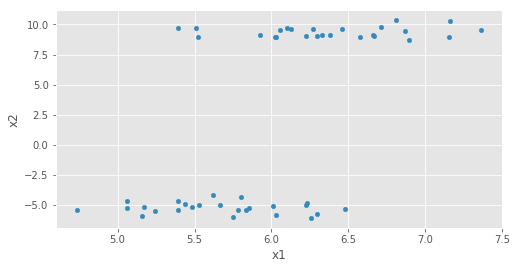

In [482]:
# Generate some wispy "sandwich" blobs
X, color = make_blobs(n_samples=50, random_state=13, centers=2, cluster_std=.5, )
X_map = map(lambda x: (x[0][0], x[0][1], color[x[1]]), zip(X, color))

points = pd.DataFrame(list(X_map), columns=["x1", "x2", "color"])
ax = points.plot(kind="scatter", x="x1", y="x2", figsize=(8, 4))

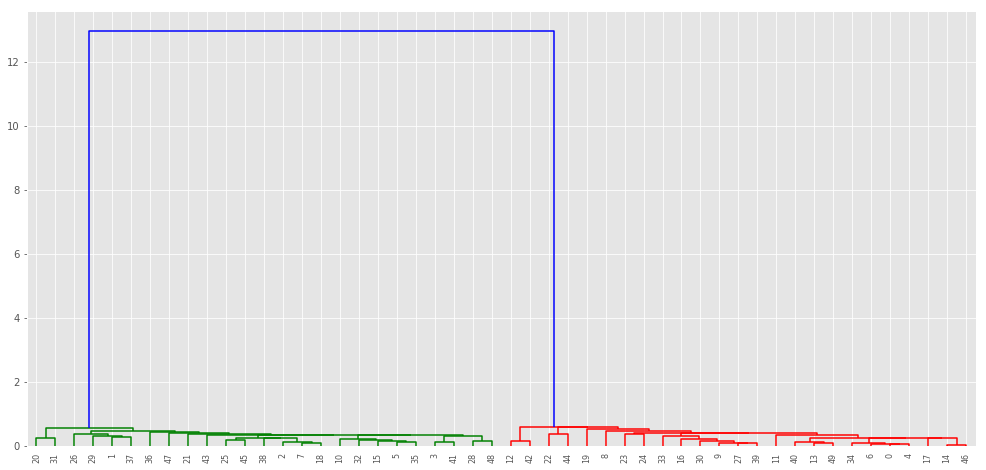

In [484]:
# Inspect Z linkage matrix
Z = linkage(X, 'single')

# Put Z in to DataFrame for easy display
link = pd.DataFrame(Z, columns=['cluster_index_left', 'cluster_index_right', 'distance', 'support'])


# Show cophenetic coefficient
c, coph_dists = cophenet(Z, pdist(X))

# We will plot a denrogram here
plt.figure(figsize=(17,8))
_ = dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)

In [501]:
link.sort_values('distance',ascending = False).head(10)

,cluster_index_left,cluster_index_right,distance,support
48,95.0,97.0,12.959169,50.0
47,62.0,96.0,0.575375,25.0
46,85.0,94.0,0.573301,23.0
45,70.0,93.0,0.552695,25.0
44,19.0,92.0,0.513076,21.0
43,84.0,91.0,0.452480,23.0
42,8.0,90.0,0.451290,20.0
41,36.0,89.0,0.412570,19.0
40,87.0,88.0,0.406505,19.0
39,47.0,86.0,0.397339,18.0


![](images/agglomarate_example.png)

### How Do We Decide Which Points to Join?

There are five common linkage methods (commonly used with euclidean distance):

##### Common Linkage Methods

- **Average** Distance between two clusters is the average distance between an observation in one cluster and an observation in the other cluster
- **Centroid** Distance between two clusters is the distance between the cluster centroids.
- **Complete (Maximum)** The distance between two clusters is the maximum distance between an observation in one cluster and an observation in the other cluster.
- **Single (Minimum)** The distance between two clusters is the minimum distance between the closest points between clusters.
- **Ward** Minimizes variance using the median distance between points within each cluster.  



##### Complete (Max)
![](images/max.png)

##### Single (Min)
![](images/min.png)

##### Average
![](images/average.png)

##### Centroid
![](images/centroid.png)

##### Ward
Chooses the clusters that have the lowest within cluster variance.

- Find the mean point of each cluster
- Calculate the variance using that mean
- See the variance for difference cluster combinations

$$variance = \frac {\sum{(x_i - \bar{X})^2}} {n-1}$$



### Examples of Difference, but ultimately it depends on the underlying structure of your data (try them)

##### Errors With Max
![](images/max_ex.png)


##### Errors With Min
![](images/min_ex.png)

In [516]:
df = pd.read_csv("./data/claim-income.csv", header=None)
col_names = ["claim-amount","income","coverage"]
df.columns = col_names
X = pd.DataFrame(StandardScaler().fit_transform(df[col_names]))
X.columns = col_names


X.head()

/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,claim-amount,income,coverage
0,-0.493064,-0.641149,-0.591251
1,-0.383660,-0.574335,-0.133336
2,-0.157517,-0.654512,2.419448
3,-0.501849,-0.654512,-0.576828
4,0.657964,-0.360530,0.010889


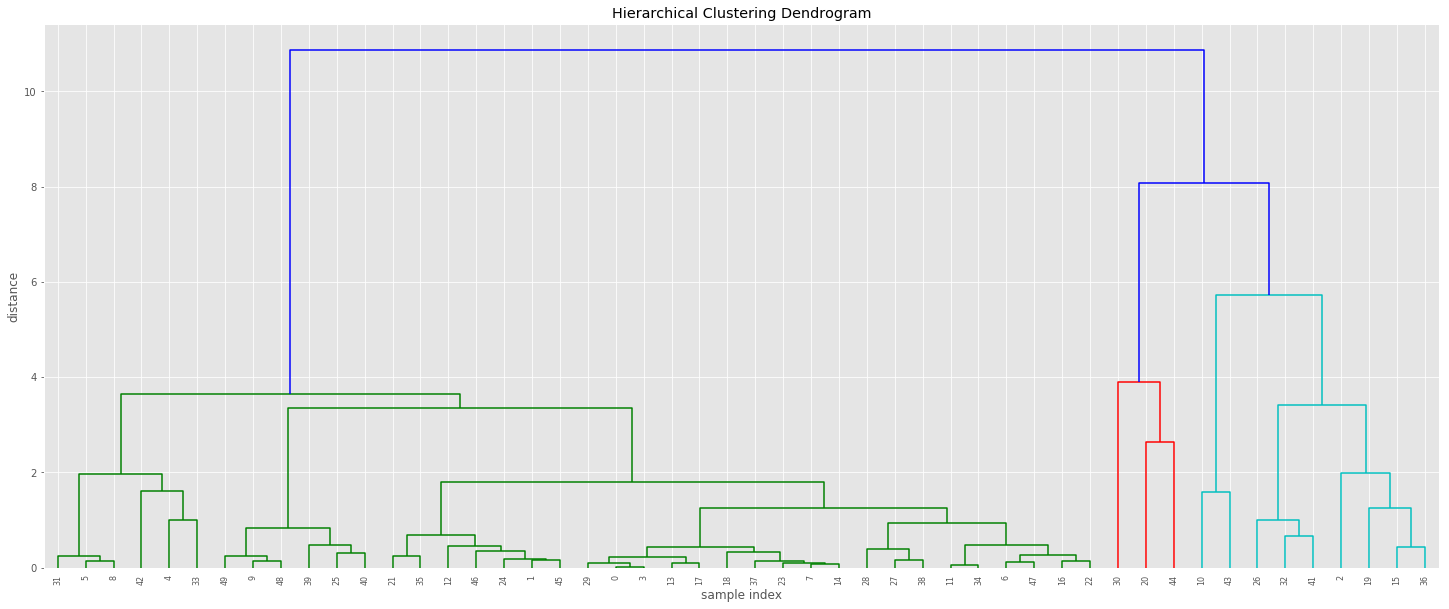

In [671]:
Z = linkage(X, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#c, coph_dists = cophenet(Z, pdist(X))
#print(c)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()




In [672]:
from scipy.cluster.hierarchy import fcluster

max_d =6.7
clusters = fcluster(Z, max_d, criterion='distance')


import pandas as pd

def add_clusters_to_frame(or_data, clusters):
    or_frame = pd.DataFrame(data=or_data)
    or_frame_labelled = pd.concat([or_frame, pd.DataFrame(clusters)], axis=1)
    return(or_frame_labelled)

result_df = add_clusters_to_frame(X, clusters)
result_df.columns = ["claim-amount","income","coverage", 'cluster']

result_df.head()

,claim-amount,income,coverage,cluster
0,-0.493064,-0.641149,-0.591251,1
1,-0.383660,-0.574335,-0.133336,1
2,-0.157517,-0.654512,2.419448,3
3,-0.501849,-0.654512,-0.576828,1
4,0.657964,-0.360530,0.010889,1


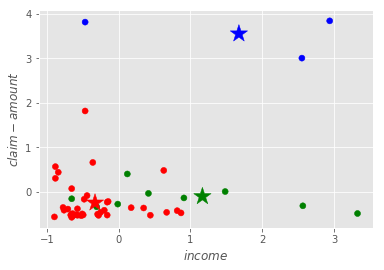

In [673]:
# Unique category labels that we set before
color_labels = result_df['cluster'].unique()

# List of RGB triplets
rgb_values = ['red','green','blue']

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))
color_map

# Finally use the mapped values
plt.scatter(result_df['income'], result_df['claim-amount'],
            c=result_df['cluster'].apply(lambda x: color_map[x]))
plt.xlabel("$income$", fontsize=12)
plt.ylabel("$claim-amount$", fontsize=12)
plt.scatter(centroids['x2'], centroids['x1'], marker='*', 
            color=rgb_values, s=330)
plt.show()

### Evaluating

##### Cophenetic correlation



### iii. Other Models


![](images/clustering_overview.png)



Density:
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

- Needs a minimum distance from cluster
- And then minimum number of points per cluster
- Makes as many clusters using these two parameters
- Needs no K

# C. Metric

Although clustering metrics are subjective you can use quantitive metrics to help guide how will your model is grouping the date.

Remember: these metrics are a guide not a definitive metric like in classification

##### i. Inertia





**Inertia** -- the sum of squared errors for each cluster. <br>
Unlike in regression, where we calculate the difference between the predicted point and the actual point, we calculate the distance from each point in the cluster to the centroid.

So the lower the inertia the higher the cluster.


![](images/sum_squared_errors.png)

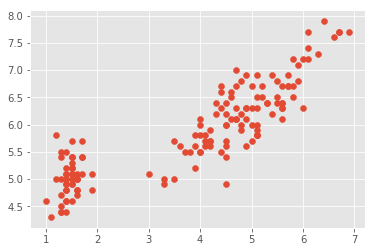

In [85]:
plt.scatter(x = iris.petal_length, y = iris.sepal_length)

In [86]:
X = iris[['petal_length', 'sepal_length']]

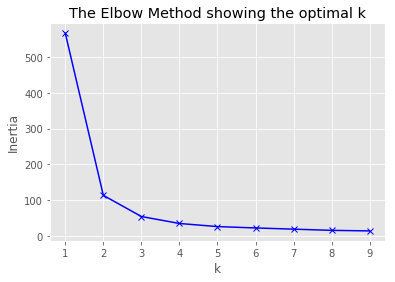

In [90]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()


> As the number of clusters k increases, inertia decreases. 
>
> **Any problems with just increasing K to get a better intertia score (thread)?**

##### ii. Silhouette 

Silhouette score takes into account:
- cohesion = average distance of points within clusters
- seperation = Average distance of points in one cluster to points in other clusters

<br>

<img src="https://snag.gy/1KE743.jpg" style="width: 600px">

<img src="https://snag.gy/6YvQPL.jpg" style="width: 600px">


<b>Silhouette score:</b>
### $s(x) = \frac{separation(X)\ -\ cohesion(X)}{max\{cohesion(X),\ separation(X)\}}$







### $SC(X) = \frac{1}{N}\sum\limits_{n=1}^{N} {s(x)}$

- -1 = Bad
- 0 = Meh
- 1 = Good

The silhouette coefficient evaluates the viability of your clusters. It is a way to quantify the "cohesion" of local points to their clusters and the separation to other clusters.

In [94]:
## Approximate implementation of silhouette
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

clusters = df.predicted.unique()
cohesion, separation = np.zeros(len(clusters)), np.zeros(len(clusters))

# Cohesion - Average distance of all points in a cluster, to each other.
# Using pairwise function on cluster 1
for index, cluster_n in enumerate(clusters):
    X = df.query("predicted == %s" % cluster_n)
    dist_matrix = pairwise_distances(X, metric="euclidean")
    cohesion[index]  =  np.mean(dist_matrix)

# Separation
for index, current_cluster in enumerate(clusters):
    current_x = df.query("predicted == %s" % current_cluster)
    other_x = df.query("predicted != %s" % current_cluster)
    dist_matrix = pairwise_distances(current_x, other_x, metric="euclidean")
    separation[index] = np.mean(dist_matrix)

(np.mean(separation) - np.mean(cohesion)) / np.maximum(np.mean(separation), np.mean(cohesion))

0.5896071911136539

In [95]:
from sklearn.metrics import silhouette_score
# Check metric

silhouette_score(df[col_names], df['predicted'])

0.6032548609661297

### Using Metrics to Pick a $K$

Since we're familliar with gridsearch now, let's try it out!  Gridsearch is typically used for supervised learning with some scoring objective for optimizing parameters in terms of `best_model`.  We don't really care about the best model as much as we want to see how either inertia or silhouette score changes based on $K$.

We will write a basic process for exploring inertia and silhouette, that you can feel free to adapt to any other ML process you might write in Sklearn for doing custom scoring (using GridsearchCV is better for supervised learning because it has cross validation built-in!).

> Visually inspecting your clusters is vastly superior to relying on programatic parameter searching for an ideal cluster for most data.  You can also invent your own evalutation metrics other than inertia or silhoette.  The world is also bigger than K-Means when it comes to cluster applications.  It's a great first stop in your journey of clustering.

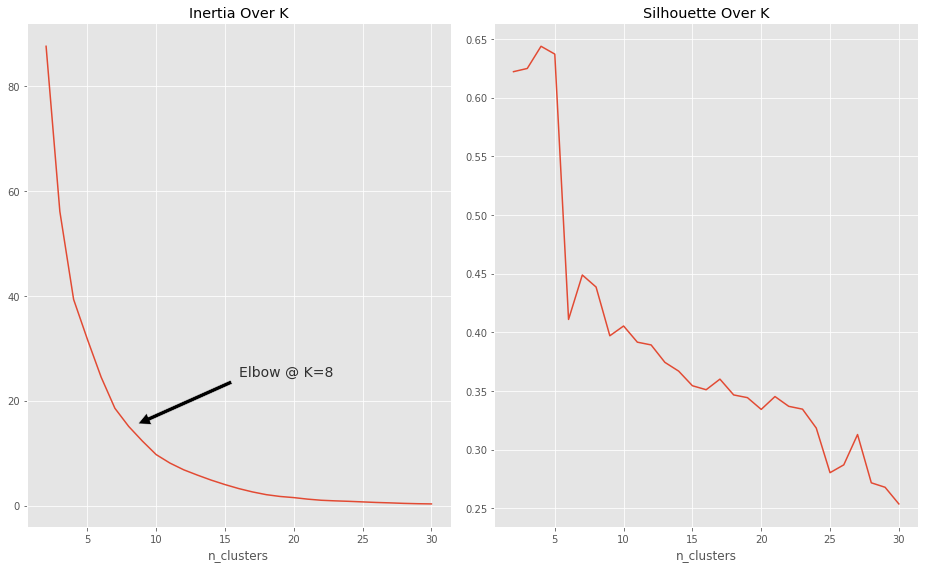

In [96]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(df)#[["x1", "x2"]])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 8))
eval_scores["inertia"].plot(ax=ax[0], title="Inertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
ax[0].annotate('Elbow @ K=8', xy = (0.25, .2),  xycoords = 'axes fraction', \
    xytext = (0.5, 0.3), fontsize = 14, \
    color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))

fig.tight_layout()


## Conclusion: K-Means tradeoffs

---

**K-Means:**
- Unsupervised clustering model
- Similar to KNN (but for “clustering”)
- Iteratively finds labels given K
- Easy to implement in sklearn
- Sensitive to shape, scale of data
- Optimal K hard to evaluate

---

| Strengths | Weaknesses |
| -- | -- |
| K-Means is popular because it's simple and computationally efficient. | However, K-Means is highly scale dependent and isn't suitable for data of varying shapes and densities. |
| Easy to see results / intuitive. | Evaluating results is more subjective, requiring much more human evaluation than trusted metrics. |

<a id='sensitive'></a>
### K-Means is sensitive to outliers

![](https://snag.gy/WFNMQY.jpg)

<a id='centroid-init'></a>
### K-Means is sensitive to centroid initialization

![](https://snag.gy/5sigCD.jpg)

<a id='resources'></a>

## Additional resources

---

- [Sci-Kit Learn Clustering Overview](http://scikit-learn.org/stable/modules/clustering.html#k-means)
- [SKLearn K-Means Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- [SKLearn Clustering Code - See _k_init__ for explanation of k++ centroid selection](https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/cluster/k_means_.py#L769)
- [Clustering Tutorial](http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/)
- [Wikipedia's Deep Dive on Clustering](https://en.wikipedia.org/wiki/K-means_clustering)
- [An excellent blog from Galvanize on K-Means Clustering](http://www.galvanize.com/blog/introduction-k-means-cluster-analysis/#.V9aXqpOAOkp)

**Some helpful stackexchange questions:**
- http://stats.stackexchange.com/questions/40613/why-dont-dummy-variables-have-the-continuous-adjacent-category-problem-in-clust
- http://stats.stackexchange.com/questions/174556/k-means-clustering-with-dummy-variables
- http://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
- http://www-01.ibm.com/support/docview.wss?uid=swg21477401


### Example:

Using customer purchase information:

- Segment users using both k-means and heirarchical clustering
- Come up with segment names
- Verify the clusters via intuition or possible using (channel or region)

### Attribute Information:

- FRESH: annual spending (m.u.) on fresh products (Continuous); 
- MILK: annual spending (m.u.) on milk products (Continuous); 
- GROCERY: annual spending (m.u.)on grocery products (Continuous); 
- FROZEN: annual spending (m.u.)on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
- CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal) 
- REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal) 

In [630]:
customers = pd.read_csv('data/Wholesale customers data.csv')
customers.columns = [i.lower() for i in customers.columns]

customers = customers[['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen']].copy(deep = True)

In [631]:
customers.head()

,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [632]:
from sklearn.preprocessing import StandardScaler

col_names = customers.columns
customers = pd.DataFrame(StandardScaler().fit_transform(customers))
customers.columns = col_names
customers.head()

/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/fernandohidalgo/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


In [633]:
from sklearn.cluster import KMeans

In [634]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score


s_score = []
inertia = []

for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(customers)
    score   = silhouette_score(customers, kmeans.labels_)
    inertia.append(kmeans.inertia_)
    
    s_score.append(score)

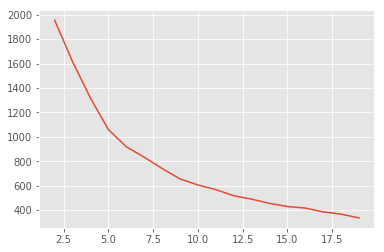

In [635]:
plt.plot(range(2,20), inertia)

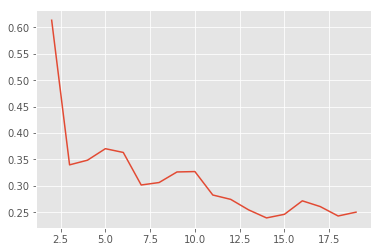

In [636]:
plt.plot(range(2,20), s_score)

In [646]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=0).fit(customers)

customers['predictions'] = kmeans.labels_

In [647]:
for i in range(k):
    
    print('cluster %r'%(i))
    print(customers[customers.predictions == i].drop('predictions', axis = 1).sum().sort_values(ascending = False).iloc[:3])
    print('   ')

cluster 0
detergents_paper    86.154095
grocery             85.461615
milk                61.747309
dtype: float64
   
cluster 1
fresh         31.712775
frozen         9.242996
delicassen   -36.193291
dtype: float64
   
cluster 2
detergents_paper    46.921199
milk                46.606142
grocery             45.312312
dtype: float64
   
cluster 3
frozen        18.819601
delicassen    17.928314
milk           6.665975
dtype: float64
   


0.5655435863411233


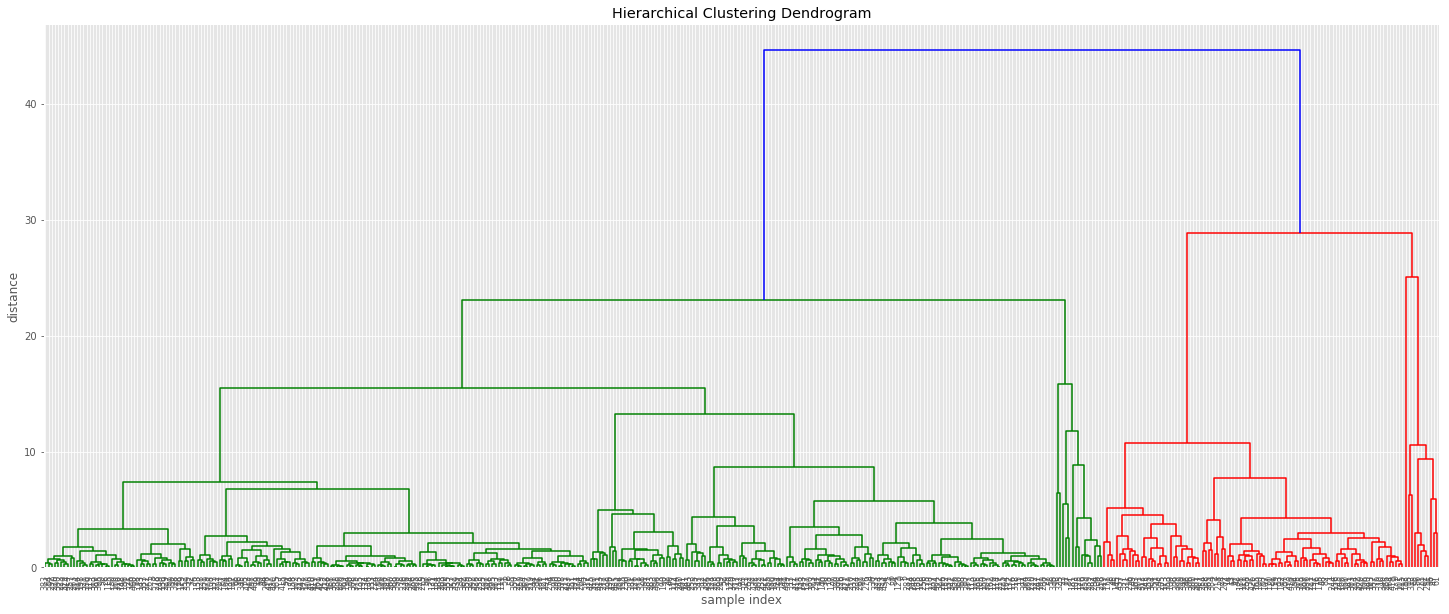

In [677]:
Z = linkage(customers, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(customers))
print(c)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()




In [675]:
from scipy.cluster.hierarchy import fcluster

max_d =17
clusters = fcluster(Z, max_d, criterion='distance')

customers['heirarchical_pred'] = clusters

In [676]:
for i in range(1, len(customers.heirarchical_pred.value_counts())+1):
    
    print('cluster %r'%(i))
    print(customers[customers.heirarchical_pred == i].drop(['predictions',
                                                           'heirarchical_pred'], axis = 1).sum().sort_values(ascending = False).iloc[:3])
    print('   ')

cluster 1
fresh         -3.096266
frozen       -10.583342
delicassen   -49.644539
dtype: float64
   
cluster 2
fresh         45.359128
frozen        33.956034
delicassen    19.913364
dtype: float64
   
cluster 3
detergents_paper    85.116183
grocery             84.960943
milk                64.264740
dtype: float64
   
cluster 4
detergents_paper    46.181658
grocery             42.756104
milk                39.219059
dtype: float64
   
cluster 5
delicassen    16.478447
frozen         6.900600
milk           5.175503
dtype: float64
   
